# Use case 

You receive a new weighing machine but notice it is not very accurate when comparing the displayed values to some real known weights; you place 50kg but it says you placed 60kg, you take a 0,5kg item but it says you took 3 itemsâ¦ do we need another better and more expensive scale? <p>
Suppose it is an industrial device whithout a calibration button but we have access to the "electronic weights" (i.e. the voltage measurements) informed by the firmware. Is there an option to use our own measures and calculus to calibrate it so we don't need to buy the expensive scale? The answer is yes becauseâ¦ the power is in our data.

In [49]:
from IPython.display import HTML
from IPython.display import display

# Taken from https://stackoverflow.com/questions/31517194/how-to-hide-one-specific-cell-input-or-output-in-ipython-notebook
tag = HTML('''<script>
code_show=false; 
function code_toggle() {
    if (!code_show){
        $('div.cell.code_cell.rendered.selected div.input').hide();
    } else {
        $('div.cell.code_cell.rendered.selected div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()">-</a>.''')
display(tag)

In [50]:
display(tag)

from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://raw.githubusercontent.com/GermanCM/univariate-linear-regression/work_in_progress/i_have_the_power_modified.JPG", width=500, height=300)

So, what do we need to make the translation from "electronic weight" to "weight in kg"? Using items of known weight, we can place them over the scale and retrieve the voltage measure, so together with the known weight, we have the pairs 'electronic weight & mass weight'. <p>
Once we have our dataset, we are ready to apply our supervised learning methodology, in this case a regression analysis. A good approach could be finding the coefficients of a line which is as close as possible to our points, i.e. implementing a linear regression right? But, are our points distributed approximately linearly? Let's check for it:

In [51]:
import pandas as pd

measures_raw_df = pd.read_csv('https://raw.githubusercontent.com/GermanCM/univariate-linear-regression/master/weights_measures.csv')

In [52]:
measures_raw_df.head(5)

,electronic_weight,mass_weight
0,761,0.0
1,765,0.0
2,872,0.0
3,23567,27.0
4,23565,27.0


In [53]:
measures_raw_df.describe()

,electronic_weight,mass_weight
count,49.000000,49.000000
mean,16648.122449,18.881633
std,6248.144227,7.389736
min,761.000000,0.000000
25%,14354.000000,16.200000
50%,18888.000000,21.500000
75%,22054.000000,25.200000
max,23593.000000,27.100000


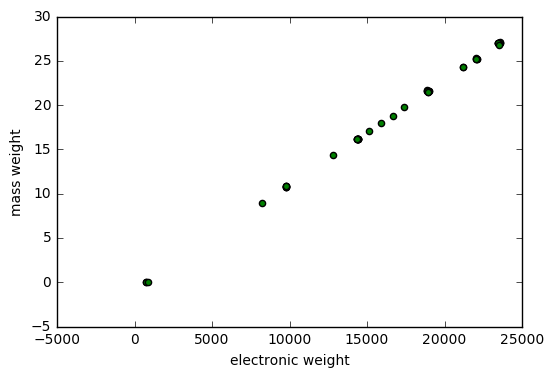

In [54]:
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt

mpl.rcParams['legend.fontsize'] = 40
x = measures_raw_df['electronic_weight']
y = measures_raw_df['mass_weight']
plt.xlabel("electronic weight")
plt.ylabel("mass weight")
 
plt.scatter(x, y, c="g")

plt.show()

VoilÃ Â , it seems to be nearly a perfect line, so good that we could even find the desired line with just 2 points? Let's zoom in:

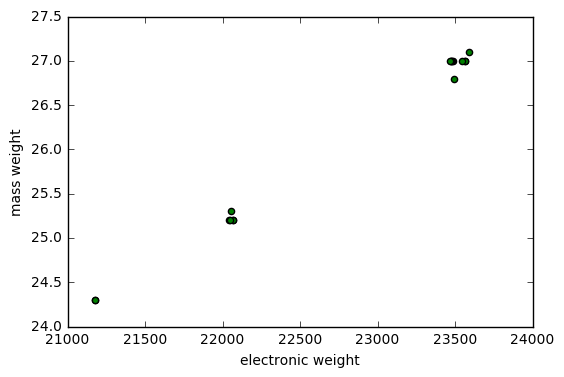

In [55]:
measures_raw_df_mini = measures_raw_df[measures_raw_df.electronic_weight>20000]

mpl.rcParams['legend.fontsize'] = 40
x = measures_raw_df_mini['electronic_weight']
y = measures_raw_df_mini['mass_weight']
plt.xlabel("electronic weight")
plt.ylabel("mass weight")
 
plt.scatter(x, y, c="g")

plt.show()

So now it does not seem we could use 2 points to find a good fitting line right? Something to remember: never rely just on your first data visualization, or try at least to check your first assumptions with extra plots or some basic calculus.<br>

So let's go on with our 49 points linear regression (you can find all the code here), and we will do it first from scratch based on the least squared errors (error = real_value-predicted_vale) using the famous gradient descent as the optimization algorithm. <br>

Steps: 
    1. write down the functions we will use for implementing linear regression
    2. split our dataset into train and test sets
    3. train our model
    4. plot the evolution of the cost function along the training epochs
    5. evaluate our model with some test data
    6. conclusions based on our use case


Below you can find the used functions for the implementation from scratch.Â <br>

But, wait, from scratch? If we use Python, can't we simply use scikit-learn and make it in few lines of code? Yes, but implementing (and understanding) this linear regression from scratch at least once in your life using gradient descent is really interesting to get a good baseline for the key ideas behind a model training, cost function, hyperparameters instead of just implementing black box wrappers, so let's go:

In [56]:
import math
import numpy as np

# get the overall cost of the model
def compute_cost(X, y, coeff):  
    '''
    inputs: 
      * 'X': features matrix (independent variables) 
      * 'y': target values (dependent variable)
      * 'coeff': regression coefficients 
    output:
      * the mean squared error (MSE)
    '''
    squared_errors = np.power((predict_output(X, coeff) - y), 2)
    return np.sum(squared_errors) / (len(X))

# returns the dependent variable (y axis) value which the model assigns to a certain independent variable (x axis) value
def predict_output(feature_matrix, coefficients):
    ''' 
    inputs: 
        * feature_matrix: two-dimensions array of the data points, where each columns is a feature and a row a point
        * coefficients: one-dimension array of estimated feature coefficients
        
    output: 
        * one-dimension array of predictions
    '''
    predictions = np.dot(feature_matrix, coefficients)
    return predictions

# derivative of the cost function, the heart of the process which gradient descent will use to minimize the cost
def feature_derivative(errors, feature):
    N = len(feature)
    derivative = (2)*np.dot(errors, feature)
    return(derivative)

# gradient descent optimization algorithm (GD)
def gradient_descent_regression(H, y, initial_coefficients, alpha, max_iterations=10000):
    '''
    inputs:
        * H: two-dimensions array of data points, where each columns is a feature and a row a point
        * y: one-dimension array with target values (dependent variable)
        * initial_coefficients: one-dimension array of initial coefficients (weights of the regression)
        * alpha: float value, it is the step size with which GD will "walk" towards the optimum values 
        * max_iterations: int, tells the program when to terminate, based on the number of epochs (i.e. runs of the algorithm)
    
    output - one-dimensional array of estimated regression coefficients
    '''
    converged = False
    w = initial_coefficients
    iteration = 0
    cost=[]
    while iteration < max_iterations:
        pred = predict_output(H, w)
        residuals = pred-y
        gradient_sum_squares = 0
        for i in range(len(w)):
            partial = feature_derivative(residuals, H[:, i])
            gradient_sum_squares += partial**2
            w[i] = w[i] - alpha*partial
        iteration += 1
        cost.append(compute_cost(H, y, w))
    return w, cost


#### Brief resume of the process for finding the linear regression coefficients via the defined functions: <br>
1-initial coefficients are initialized to random numbers, or even zero in our case, inside the 'gradient_descent_regression' methodÂ <br> 

2.-predictions are made using the current coefficients, with the 'predict_output' method <br>

3.-the gradient (first order derivate) of the residuals is made with the 'feature_derivative' method; this will let us update each weight (in our case the line slope and the intercept with the y-axis) via the gradient descent ruleÂ <br>

4.-once the max_iterations number is reached, return the final coefficients and cost (computed with 'compute_cost')
You can find below the update weight rule in gradient descent; what it does is adding, to the current weight value (the 'theta' symbol), the derivative of the cost function with a minus sign (times an alpha step size). This way, it is updated in each epoch in the "direction" towards the cost function minimum (we will see it more detail in another post):

In [57]:
display(tag)

Image(url= "https://upload.wikimedia.org/wikipedia/commons/6/68/Gradient_descent.jpg", width=300, height=300)

We won't use in this case any early stopping value if a certain tolerance is reached in the cost function; we will only use the max_iterations value instead, which is far enough for our purpose.

### Train-test split <br>
 
We will use the 'train_test_split' package from scikit-learn to split our data into training and test sets:

In [58]:
from sklearn.model_selection import train_test_split

n = len(measures_raw_df)
H = measures_raw_df

X_train, X_test, y_train, y_test = train_test_split(H['electronic_weight'], H['mass_weight'], test_size=0.2, random_state=21)


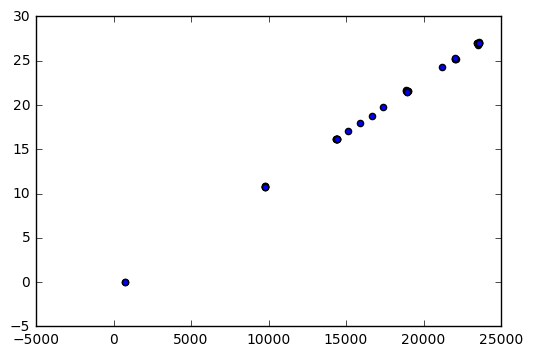

In [59]:
# Train set
plt.scatter(X_train, y_train)

plt.show()

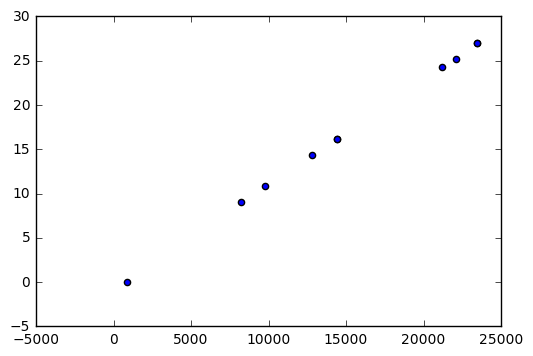

In [60]:
# Test set
plt.scatter(X_test, y_test)

plt.show()

In [61]:
def normalize_features(df):
    """
    Normalize the features in the data set.
    
    Returns the normalized values, mean and standard deviation fo each feature
    """
    mu = df.mean()
    sigma = df.std()
    
    if (sigma == 0).any():
        raise Exception("One or more features had the same value for all samples, and thus could " + \
                         "not be normalized. Please do not include features with only a single value " + \
                         "in your model.")
    df_normalized = (df - df.mean()) / df.std()

    return df_normalized, mu, sigma

def find_r2_score(labels_test, predicted_outputs):
    from sklearn.metrics import r2_score
    corr_coeff = r2_score(labels_test, predicted_outputs)
    print('the value of r2 is: ', corr_coeff)

Another function to use in our implementation of the linear regression via GD (Gradient Descent) from scratch is the normalization of the features; again, it is not the goal of this post to go into details for this, but scaling is necessary for this implementation, and we will use the standardization to rescale our values to the range 0â1. <p>
    
Now that we have all our functions and our dataset split into train and test groups, let's train our model. 
    
### Model training

In [62]:
display(tag)

from IPython.display import Image
Image(url="https://tenor.com/view/workout-rhino-unicorn-goals-body-sizes-gif-4905556.gif")

So in our simple case for linear regression, what we expect is to obtain a couple of values, the first weight (intercept), and the second weight (actually the slope of our line), according to:

In [64]:
display(tag)

Image(url= "https://raw.githubusercontent.com/GermanCM/univariate-linear-regression/work_in_progress/linear_eq.PNG", width=200, height=200)

Take into account that those values will work for scaled data, i.e., applying the same standardization operation (we'll see it in a bit when predicting unseen data). If we wait until our cute rhino makes an effort to improve its fitness:

In [63]:
feature_train_matrix = np.zeros(len(X_train)*2) 
feature_train_matrix.shape = (len(X_train), 2) 
feature_train_matrix[:,0] = 1 
feature_train_matrix[:,1] = X_train

feature_train_matrix, train_mu, train_sigma = normalize_features(feature_train_matrix)

initial_coefficients = np.zeros(len(feature_train_matrix[0]))

coef, cost = gradient_descent_regression(feature_train_matrix, y_train, initial_coefficients, 6e-5, \
                                         max_iterations=10000) 

print('first weight: {}'.format(coef[0]))
print('second weight: {}'.format(coef[1]))
print('cost: {}'.format(cost[-1]))

first weight: -10.32256050647614
second weight: 11.191002738125563
cost: 0.006022601073742206


As we can also see, our model returns a final squared mean error 0.006 <p>
Nevertheless, we are interested in the root means squared error, which is in the same units as our features: 

In [65]:
train_mse = compute_cost(feature_train_matrix, y_train, coef) 
np.around(np.sqrt(train_mse), decimals=3)

0.078

### Plot of the cost evolution along the training process:

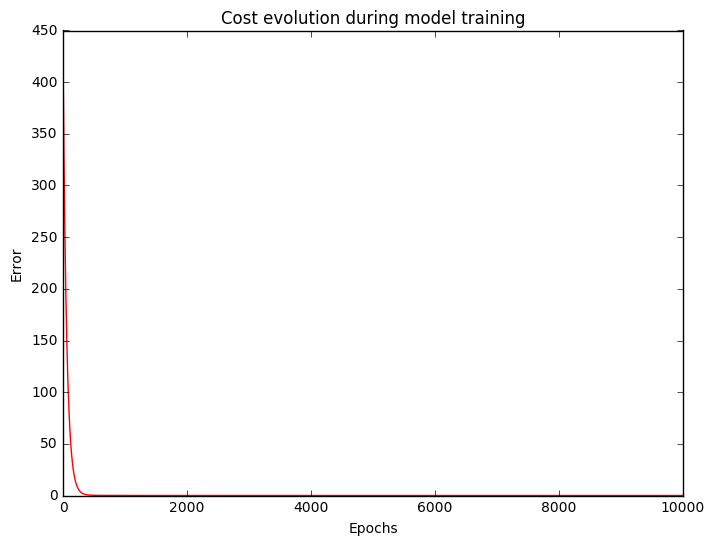

In [66]:
fig, ax = plt.subplots(figsize=(8,6))  
ax.plot(np.arange(len(cost)), cost, 'r')  
ax.set_xlabel('Epochs')  
ax.set_ylabel('Error')  
ax.set_title('Cost evolution during model training')   
plt.show()

### Model evaluation: <br>

So now let's apply our model to unseen data from the test dataset: 

In [67]:
n = len(X_test)
feature_test_matrix = np.zeros(n*2) 
feature_test_matrix.shape = (n, 2) 
feature_test_matrix[:,0] = 1 
feature_test_matrix[:,1] = X_test

# We use the same mean and std obtained for the train set:
feature_test_matrix = (feature_test_matrix - train_mu) / train_sigma 

#calculamos mse en test set:
test_mse = compute_cost(feature_test_matrix, y_test, coef) 
np.sqrt(test_mse)

0.10634757043674785

The RMSE (root mean squared error) on unseen data seems quite ok, so let's predict on some values of the test set: 

In [68]:
def normalize_and_predict(feature_values):
    X = [feature_values]
    H = pd.DataFrame({'X': X})

    # for a single point:
    n = 1
    feature_to_predict = np.zeros(n*2)
    feature_to_predict.shape = (n, 2)
    feature_to_predict[:,0] = 1
    feature_to_predict[:,1] = H['X']

    #normalize test feature with the same values as in the training set:
    feature_to_predict = (feature_to_predict - train_mu) / train_sigma  

    return predict_output(feature_to_predict, coef)
    
print(normalize_and_predict(8241))

[ 8.95052887]


It looks quite nice for the single value x = 8241 to get the prediction 8.95 compared to the expected 9.0; we actually expected that good result in average, since we obtained a RMSE = 0.1. <p>
Let's find the predictions for each value in our test dataframe and compare it with the expected values: 

In [69]:
test_df = pd.DataFrame({'x': X_test, 'y': y_test})
test_df

,x,y
7,22068,25.2
43,8241,9.0
42,9752,10.9
25,21180,24.3
14,14393,16.2
2,872,0.0
23,23471,27.0
30,12813,14.4
17,14403,16.2
46,23471,27.0


In [70]:
preds_reg_from_scratch = [float(np.around(normalize_and_predict(ft), decimals=4)) for ft in test_df['x']]
preds_reg_from_scratch

[25.2811,
 8.9505,
 10.7351,
 24.2324,
 16.2165,
 0.2472,
 26.9382,
 14.3504,
 16.2283,
 26.9382]

In [71]:
test_df['preds_reg_from_scratch'] = preds_reg_from_scratch
test_df

,x,y,preds_reg_from_scratch
7,22068,25.2,25.2811
43,8241,9.0,8.9505
42,9752,10.9,10.7351
25,21180,24.3,24.2324
14,14393,16.2,16.2165
2,872,0.0,0.2472
23,23471,27.0,26.9382
30,12813,14.4,14.3504
17,14403,16.2,16.2283
46,23471,27.0,26.9382


In [72]:
display(tag)

Image(url= "https://raw.githubusercontent.com/GermanCM/univariate-linear-regression/work_in_progress/NICE_RESULTS.PNG", width=350, height=350)

### Linear regression with scikit-learn 
<br> 
So after implementing our linear regressor from scratch understanding all the steps (which is quite useful to get the key ideas behind machine learning algorithms), let's see how to implement it and serialize it with scikit-learn much faster:

In [73]:
from sklearn import linear_model

linear_reg = linear_model.LinearRegression()
linear_reg.fit(X_train.values.reshape((len(X_train),1)), y_train.values.reshape((len(X_train),1)))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Notice with this option we do not need to explicitely normalize our data points, already carried out by scikit; let's see how good the predictions are using the same test dataframe as before: 

In [74]:
linear_reg.predict(8241)

array([[ 8.95084297]])

In [75]:
preds_reg_scikit = [float(np.around(linear_reg.predict(ft), decimals=4)) for ft in test_df['x']]
preds_reg_scikit

[25.2811,
 8.9508,
 10.7354,
 24.2323,
 16.2166,
 0.2478,
 26.9381,
 14.3506,
 16.2284,
 26.9381]

In [76]:
test_df['preds_reg_scikit'] = preds_reg_scikit
test_df

,x,y,preds_reg_from_scratch,preds_reg_scikit
7,22068,25.2,25.2811,25.2811
43,8241,9.0,8.9505,8.9508
42,9752,10.9,10.7351,10.7354
25,21180,24.3,24.2324,24.2323
14,14393,16.2,16.2165,16.2166
2,872,0.0,0.2472,0.2478
23,23471,27.0,26.9382,26.9381
30,12813,14.4,14.3504,14.3506
17,14403,16.2,16.2283,16.2284
46,23471,27.0,26.9382,26.9381


And we can see the predictions with the scikit-learn model are basically the same, just a very little difference usually in the 4th decimal point. Good to see that we can reproduce scikit results with our implementation from scratchÂ :-) <p>
One more question we might ask ourselves is, ok nice results but is it useful for my real life use case? Well it depends on your real use case; if the mean (could also be the median) difference between the prediction and the real value is below the uncertainty that you are willing to accept, then it is a good result. In my case, I needed to be able to detect a change of at least one third of kilogram, so these results are very good.

Another question it might arise (and this is the last one for now in this post) is: what happens if we make more measurements for larger weights on the weighing scale? Does it keep being so linear that we can apply the same algorithm? I'll show it in the next postÂ :)

### Summary of our use case

* Weighing scale not calibrated; electronic weight (i.e. voltages) data retrieved from its firmware
* Dataset built with the pair of values 'electronic weight - known weight in kilograms'
* Univariate linear regression from scratch to find the equation to translate electronic weight into real mass weight
* Comparison with scikit-learn results  
* Validation of results in the frame of our real use case


### Next steps 

* Will our points follow the same linearity for higher weights?  
* Can we still use the same process to cover these new data?

We will see in the part 2 of this seriesÂ :)

#### Interesting sources:
https://github.com/llSourcell/Intro_to_the_Math_of_intelligence <p>
http://charlesfranzen.com/posts/multiple-regression-in-python-gradient-descent/ <p>
https://www.johnwittenauer.net/machine-learning-exercises-in-python-part-1/
